Saved four_bar_linkage.gif


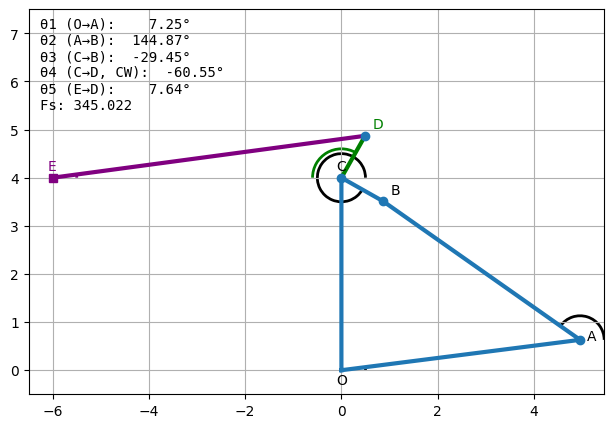

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Arc
from IPython.display import HTML

# -----------------------------
# Link lengths
# -----------------------------
l_1 = 5
l_2 = 5.0
l_3 = 1
l_4 = 4.0
l_5 = 1

# -----------------------------
# Theta1 range
# -----------------------------
theta1 = np.linspace(0, 0.5, 400)

# -----------------------------
# Ground points
# -----------------------------
O = np.array([0.0, 0.0])
C = np.array([0.0, l_4])
E = np.array([C[0] - 6.0, C[1]])

# -----------------------------
# Storage
# -----------------------------
A = np.zeros((len(theta1), 2))
B = np.zeros((len(theta1), 2))
D = np.zeros((len(theta1), 2))

# -----------------------------
# Geometry solver
# -----------------------------
for i, t1 in enumerate(theta1):
    A[i] = O + np.array([l_1 * np.cos(t1), l_1 * np.sin(t1)])
    d = np.linalg.norm(C - A[i])

    if d > l_2 + l_3 or d < abs(l_2 - l_3):
        B[i] = np.nan
        D[i] = np.nan
        continue

    a = (l_2**2 - l_3**2 + d**2) / (2 * d)
    h = np.sqrt(max(0.0, l_2**2 - a**2))
    P = A[i] + a * (C - A[i]) / d

    B[i, 0] = P[0] + h * (C[1] - A[i, 1]) / d
    B[i, 1] = P[1] - h * (C[0] - A[i, 0]) / d

    v3 = C - B[i]
    v3_hat = v3 / np.linalg.norm(v3)
    n_hat = np.array([v3_hat[1], -v3_hat[0]])
    D[i] = C + l_5 * n_hat

# -----------------------------
# Remove invalid
# -----------------------------
valid = ~np.isnan(B[:, 0])
theta1 = theta1[valid]
A = A[valid]
B = B[valid]
D = D[valid]

# -----------------------------
# Spring force
# -----------------------------
L0 = 10
k = 100.0
spring_len = np.linalg.norm(D - E, axis=1)
Fs = k * np.abs(spring_len - L0)

# -----------------------------
# Angle helpers
# -----------------------------
def angle_deg(p1, p2):
    v = p2 - p1
    return np.degrees(np.arctan2(v[1], v[0]))


def small_angle_deg(th):
    th = (th + 180) % 360 - 180
    if th > 90:
        th -= 180
    if th < -90:
        th += 180
    return th


# -----------------------------
# Angle arrays
# -----------------------------
th1_arr = np.zeros(len(A))
th2_arr = np.zeros(len(A))
th3_arr = np.zeros(len(A))
th4_arr = np.zeros(len(A))
th5_arr = np.zeros(len(A))

# -----------------------------
# Plot limits
# -----------------------------
all_x = np.hstack([O[0], C[0], E[0], A[:, 0], B[:, 0], D[:, 0]])
all_y = np.hstack([O[1], C[1], E[1], A[:, 1], B[:, 1], D[:, 1]])
pad = 0.5
xmin, xmax = all_x.min() - pad, all_x.max() + pad
ymin, ymax = all_y.min() - pad, all_y.max() + pad

# -----------------------------
# Figure setup
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_aspect('equal')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax + 2)
ax.grid(True)

# We'll not reuse patch/artist references across frames because we clear the axes each frame.
# -----------------------------
# Update (full redraw each frame)
# -----------------------------
def update(i):
    # Clear axes for a full redraw (guaranteed clean GIF frames)
    ax.clear()

    # Restore axes settings
    ax.set_aspect('equal')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax + 2)
    ax.grid(True)

    # Draw fixed target
    ax.plot(E[0], E[1], 's', color='purple', zorder=5)

    # Draw main 4-bar links
    x_link = [O[0], A[i, 0], B[i, 0], C[0], O[0]]
    y_link = [O[1], A[i, 1], B[i, 1], C[1], O[1]]
    ax.plot(x_link, y_link, lw=3, color='C0', zorder=4)

    # Link 5 (C to D)
    ax.plot([C[0], D[i, 0]], [C[1], D[i, 1]], lw=3, color='green', zorder=4)

    # Spring (D to E)
    ax.plot([D[i, 0], E[0]], [D[i, 1], E[1]], lw=3, color='purple', zorder=3)

    # Traces (use slices to avoid appending lists)
    if i > 0:
        ax.plot(B[: i + 1, 0], B[: i + 1, 1], lw=1, alpha=0.6, zorder=1)
        ax.plot(D[: i + 1, 0], D[: i + 1, 1], lw=1, linestyle='--', zorder=1)

    # Joints
    ax.plot([A[i, 0], B[i, 0], C[0], D[i, 0]],
            [A[i, 1], B[i, 1], C[1], D[i, 1]],
            'o', zorder=6)

    # Angles (numerical)
    th1 = angle_deg(O, A[i])
    th2 = angle_deg(A[i], B[i])
    th3 = angle_deg(C, B[i])
    th4 = small_angle_deg(-angle_deg(C, D[i]))
    th5 = angle_deg(E, D[i])

    th1_arr[i] = th1
    th2_arr[i] = th2
    th3_arr[i] = th3
    th4_arr[i] = th4
    th5_arr[i] = th5

    angle_text = (
        f"θ1 (O→A): {th1:7.2f}°\n"
        f"θ2 (A→B): {th2:7.2f}°\n"
        f"θ3 (C→B): {th3:7.2f}°\n"
        f"θ4 (C→D, CW): {th4:7.2f}°\n"
        f"θ5 (E→D): {th5:7.2f}°\n"
        f"Fs: {Fs[i]:7.3f}"
    )
    ax.text(0.02, 0.98, angle_text, transform=ax.transAxes,
            va='top', ha='left', fontsize=10, family="monospace", zorder=10)

    # Arcs (drawn as fresh patches each frame)
    # arc1: at O from 0 -> th1
    arc1 = Arc(O, 1.0, 1.0, theta1=0, theta2=th1, color='black', lw=2)
    ax.add_patch(arc1)

    # arc2: at A
    arc2 = Arc((A[i, 0], A[i, 1]), 1.0, 1.0, theta1=0, theta2=th2, color='black', lw=2)
    ax.add_patch(arc2)

    # arc3: at C (C->B)
    arc3 = Arc(C, 1.0, 1.0, theta1=0, theta2=th3, color='black', lw=2)
    ax.add_patch(arc3)

    # arc4: from link angle to 180 deg at C (green)
    link5_ccw = angle_deg(C, D[i])
    arc4 = Arc(C, 1.2, 1.2, theta1=link5_ccw, theta2=180, color='green', lw=2)
    ax.add_patch(arc4)

    # arc5: at E
    arc5 = Arc(E, 1.0, 1.0, theta1=0, theta2=th5, color='purple', lw=2)
    ax.add_patch(arc5)

    # Labels: add as normal text (safe because axes were just cleared)
    offset = 0.15
    ax.text(O[0] - 0.1, O[1] - 2 * offset, 'O', color='black', zorder=11)
    ax.text(A[i, 0] + offset, A[i, 1], 'A', color='black', zorder=11)
    ax.text(B[i, 0] + offset, B[i, 1] + offset, 'B', color='black', zorder=11)
    ax.text(C[0] - 0.1, C[1] + offset, 'C', color='black', zorder=11)
    ax.text(D[i, 0] + offset, D[i, 1] + offset, 'D', color='green', zorder=11)
    ax.text(E[0] - 0.1, E[1] + offset, 'E', color='purple', zorder=11)

    # Return empty list because we're not using blitting (not required)
    return []

# -----------------------------
# Animation (full redraw; blit=False)
# -----------------------------
ani = FuncAnimation(
    fig,
    update,
    frames=len(A),
    interval=30,
    blit=False
)

# Display inline
display = HTML(ani.to_jshtml())
display

# Save GIF (force full-frame save)
ani.save(
    "four_bar_linkage.gif",
    writer="pillow",
    fps=30,
    savefig_kwargs={'facecolor': fig.get_facecolor()}
)

print("Saved four_bar_linkage.gif")
